In [ ]:
import torchvision
import torch
import sys

sys.path.append("..")

from torch.utils.data import DataLoader, Dataset
from utils.model_util import LeNet5, CNN, MLP
from utils.train_util import *

model = LeNet5(28, 28, 1, 10).cuda()
train_dataset_loader = DataLoader(
    dataset=torchvision.datasets.MNIST(
        root='../data/raw-data/',
        train=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=600,
    shuffle=False)
test_dataset_loader = DataLoader(
    dataset=torchvision.datasets.mnist.MNIST(
        root='../data/raw-data/',
        transform=torchvision.transforms.ToTensor()),
    batch_size=32,
    shuffle=False)
test_dataset = torchvision.datasets.mnist.MNIST(
    root='../data/raw-data/',
    transform=torchvision.transforms.ToTensor())

opti = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
for data, target in train_dataset_loader:
    opti.zero_grad()
    output = model(data.cuda())
    loss = criterion(output, target.cuda())
    loss.backward()
    print(loss.item())
    opti.step()

print(loss, type(loss))
print(loss.item(), type(loss.item()))

model = LeNet5(28, 28, 1, 10).cuda()
train_dataset_loader = DataLoader(
    dataset=torchvision.datasets.MNIST(
        root='../data/raw-data/',
        train=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=600,
    shuffle=False)
test_dataset_loader = DataLoader(
    dataset=torchvision.datasets.mnist.MNIST(
        root='../data/raw-data/',
        transform=torchvision.transforms.ToTensor()),
    batch_size=32,
    shuffle=False)

opti = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
loss_sum = 0
for data, target in train_dataset_loader:
    opti.zero_grad()
    output = model(data.cuda())
    loss = criterion(output, target.cuda())
    # print(f'loss_sum = {loss_sum:<20}', end=' | ')
    loss.backward()
    loss_sum += loss.item()
    # print(f'loss = {loss.item():<20}')
    opti.step()

def eval_model(model, dataset, device):
    '''
    评估模型
    '''
    model_copy = deepcopy(model).eval()
    correct = 0
    data_loader = DataLoader(dataset, batch_size=32)
    for images, targets in data_loader:
        outputs = model_copy(images.to(device))
        _, predicted = torch.max(outputs, 1)
        correct += torch.eq(predicted, targets.to(device)).sum()
    # print(f'Test Accuracy: {100 * correct / total:.2f}%')
    accuracy = correct / len(dataset)
    return accuracy

eval_model(model, test_dataset, 'cuda')

model_copy = deepcopy(model).eval()
model_copy.eval()
model_copy.cuda()
correct = 0
total = 0
data_loader = test_dataset_loader
for images, targets in data_loader:
    outputs = model_copy(images.cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets.cuda()).sum().item()
    break
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

In [ ]:
for i in range(8, 13):
    print(f'{i:<10}|')
    print(f'{i:.2f}|')

In [ ]:
def get_list(len_list, term=[]):
    '''
    返回一个全是空列表的列表
    '''
    list_return = []
    for _ in range(len_list):
        list_return.append(term)
    return list_return

num_all_client = 6
num_all_server = 2

server_model = get_list(num_all_server)
server_accuracy = get_list(num_all_server)
client_accuracy = get_list(num_all_client)
server_client_model = get_list(num_all_server)
server_model_distillation_accuracy = get_list(num_all_server)

print(client_accuracy)

In [ ]:
import torch
import sys

sys.path.append('..')

from utils.data_util import *
from utils.train_util import *
from utils.model_util import *
from utils.lib_util import *

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

save_path = '../data/dealed-data/'
train_dataset_o, test_dataset_o = get_dataset(dataset='cifar10')
train_dataset_splited = split_data(train_dataset_o)
idx_client_target = train_data_split(train_dataset_splited, range(3))
all_target = train_dataset_splited.keys()

train_dataset_client = list_same_term(3)
for client in range(3):
    for target in all_target:
        train_dataset_client_new = [train_dataset_splited[target][idx]
                                    for idx in idx_client_target[client][target]]
        train_dataset_client[client].extend(train_dataset_client_new)

public_idx, test_idx = split_idx_proportion(
    number_list(len(test_dataset_o)), [0.2, 0.8])
public_dataset = DealDataset(test_dataset_o, public_idx)
test_dataset = DealDataset(test_dataset_o, test_idx)

model = CNN(32, 32, 3, 10)
trained_model1, _ = train_model(
    model=model,
    dataset=train_dataset_client[0],
    device=device,
    epochs=10)
print('mode 1: ', eval_model(trained_model1, test_dataset, device))
trained_model2, _ = train_model(
    model=model,
    dataset=train_dataset_client[1],
    device=device,
    epochs=10)
print('mode 2: ', eval_model(trained_model2, test_dataset, device))

trained_model3, _ = train_model(
    model=model,
    dataset=train_dataset_client[2],
    device=device,
    epochs=10)
print('mode 3 before distill: ', eval_model(trained_model3, test_dataset, device))

trained_model4, _ = train_model(
    model=trained_model3,
    dataset=public_dataset,
    device=device,
    epochs=10)
print('mode 3 after distill: ', eval_model(trained_model4, test_dataset, device))

trained_model5, _ = train_model_disti(
    model=trained_model3,
    neighbor_server_model=[trained_model1, trained_model2],
    weight=torch.tensor([0.5, 0.5]),
    dataset=public_dataset,
    alpha=0.5,
    device=device,
    epochs=10)
print('mode 3 train only in public dataset: ', eval_model(trained_model5, test_dataset, device))

In [ ]:
import torch
import sys

sys.path.append('..')

from utils.data_util import *
from utils.train_util import *
from utils.model_util import *
from utils.lib_util import *

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

save_path = '../data/dealed-data/'
train_dataset_o, test_dataset_o = get_dataset(dataset='cifar100')
print(type(train_dataset_o.targets), len(train_dataset_o.targets))

In [ ]:
import torch
import sys

sys.path.append('..')

from utils.data_util import *
from utils.train_util import *
from utils.model_util import *
from utils.lib_util import *

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

save_path = '../data/dealed-data/'
train_dataset_o, test_dataset_o = get_dataset()
print(type(train_dataset_o.targets))

In [ ]:
import torch

a = torch.rand(3, 4)
b = a.to('cuda')

print(b)
print(b[0])

In [ ]:
import random, copy

a = [i for i in range(10)]
b = [i+100 for i in range(10)]
c = {'a': a, 'b': b}

d = copy.deepcopy(c['a'])
random.shuffle(d)

print(a)
print(b)
print(c)
print(d)

In [ ]:
a = [i for i in range(10)]
b = a[1:3]
c = a[1:]
print(a, b, c)
a.append(['k'])
print(a)
a.extend(['k'])
print(a)

In [ ]:
import numpy

a = [i for i in range(10)]
b = numpy.random.choice(a, 3, replace=True).tolist()
print(b, type(b))

for i, c in enumerate(b):
    print(i)
    print(c, type(c))

In [ ]:
import sys

sys.path.append('./utils/')

from utils.data_util import *

_, data, _, _, _ = get_dataset()
DataSplit = SplitData(dataset=data)
# splited_data = DataSplit.split_data()
client_data = DataSplit.part_target(2, 3, [[0, 1], [2, 3], [4, 5]])

In [ ]:
for i, (data, target) in enumerate(client_data[0]):
    for j, (data_, target_) in enumerate(client_data[1]):
        b = 0
        if target_ == target:
            a = torch.eq(data_, data)
            for i in a[0]:
                if False in i:
                    b += 1
            if b:
                continue
            else:
                print('same')

In [ ]:
import torch, torchvision

from utils.model_util import LeNet5
from utils.data_util import *
from utils.train_util import *

device='cuda'

train_dataset, test_dataset, c, h, w = get_dataset()
num_target = len(set(test_dataset.targets.tolist()))

model1 = LeNet5(h, w, c, num_target)
model2 = LeNet5(h, w, c, num_target)

DataSplited = SplitData(train_dataset)
splited_dataset = DataSplited.all_iid(5, 1000)
model1_trained = train_model(
    model=model1,
    dataset=splited_dataset[0],
    device=device)
model2_disti = train_model_disti(
    model=model2,
    dataset=splited_dataset[1],
    neighbor_server_model=[model1],
    weight=torch.tensor([1]),
    alpha=0.5,
    device=device)

eval_model1 = eval_model(
    model=model1,
    dataset=test_dataset,
    device=device)
print(eval_model1)
eval_model2 = eval_model(
    model=model2,
    dataset=test_dataset,
    device=device)
print(eval_model2)

In [ ]:
import torch

if torch.cuda.is_available():
    device = 'cuda'
elif torch.mps:
    print(torch.mps)
else:
    device = 'cpu'
print(device)

In [ ]:
import torch

print(torch.mps)
mps_device = torch.device("mps")
print(mps_device, type(mps_device))

In [ ]:
import torch

if torch.backends.cuda.is_built():
    print('cuda')

In [ ]:
import torch

a = torch.rand(3, 4)
print(a)
print(a.data)

In [ ]:
import torch
import matplotlib.pyplot as plt

x = [i for i in range(10)]
y = torch.rand(4, 10)
line_list = []
for i in range(4):
    line_list.append(plt.plot(x, y[i, :]))

plt.show()

In [ ]:
import sys
import torch
import torchvision

sys.path.append('..')
from utils.model_util import LeNet5
from torch.utils.data import Dataset, DataLoader
from utils.data_util import get_dataset
from utils.train_util import train_model, eval_model


train_dataset = torchvision.datasets.MNIST(
            root='../data/raw-data',
            train=True,
            transform=torchvision.transforms.ToTensor(),
            download=True)

model = LeNet5(28, 28, 1, 10)
train_model(model=model, dataset=train_dataset, device='cuda')

In [ ]:
a = 1
b = [a, a, a, a]
print(b)

b[0] = 2
print(b)

In [ ]:
a = []
for i in range(5):
    c = 1
    a.append(c)
print(id(a[0]), id(a[1]))
a[0] += 2
print(id(a[0]), id(a[1]))
print(a)

In [ ]:
a = 0
b = 0
print(id(a), id(a))

In [ ]:
from copy import deepcopy

def empty_list(len_list, term=[]):
    '''
    返回一个全是空列表的列表
    '''
    list_return = []
    for _ in range(len_list):
        list_return.append(deepcopy(term))
    return list_return

a = empty_list(3)
b = empty_list(3)
print(id(a), id(b))
print(id(a[0]), id(b[0]))
print(id(a[0]), id(a[1]))

In [ ]:
class A:
    def __init__(self) -> None:
        pass

a = A()
b = A()
print(id(a), id(b))

In [ ]:
from utils.data_util import *

_, dataset, _, _, _ = get_dataset()
print(len(dataset))
print(type(dataset[3]), type(dataset[3][1]))
# for i, data in enumerate(dataset):
#     print(type(i), type(dataset[i]))

In [ ]:
from utils.data_util import *

_, dataset, _, _, _ = get_dataset()

client_data =split_parts_random(dataset, [2, 3, 4])
print(len(client_data), len(client_data[0]), len(client_data[1]))

In [ ]:
from utils.lib_util import get_logger

massage = 'test'
file_name = 'test.txt'

logger = get_logger(file_name)
logger.info(massage)

In [ ]:
import random
import matplotlib.pyplot as plt


x = [i for i in range(100)]
y = [random.random() for i in range(100)]

plt.plot(x, y)

plt.show()

In [ ]:
import numpy as np

aa = int(np.log2(8 - 1)) + 1
rota = [i for i in range(int(np.log2(8 - 1)) + 1)]

source = (2 - rota[2 % len(rota)]) % 8
dest = (2 + rota[2 % len(rota)]) % 8

print(aa, a, source, dest)

In [ ]:
# intra_comm_bcast.py

import numpy as np
from mpi4py import MPI


comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# broadcast a generic object by using bcast
if rank == 1:
    obj = {'a': 1}
else:
    obj = None

obj = comm.bcast(obj, root=1)
print('rank %d has %s' % (rank, obj))

# broadcast a numpy array by using Bcast
if rank == 2:
    ary = np.arange(10, dtype='i')
else:
    ary = np.empty(10, dtype='i')

comm.Bcast(ary, root=2)
print('rank %d has %s' % (rank, ary))

In [ ]:
import numpy as np
#下面这个引用就是上面文章提供的脚本mnist.py
from mnist import load_mnist
from PIL import Image

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True,
normalize=False)
img = x_train[0]
label = t_train[0]
print(label) # 5

#这里是把二维图像铺平成一维存放了
print(img.shape)          # (784,1)
img = img.reshape(28, 28) # 还原为二维
print(img.shape)          # (28, 28)

img_show(img)


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_tf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

batch_size = 32
# 读取测试数据，train=True读取训练数据；train=False读取测试数据
train_dataset = datasets.MNIST(root='./data/raw-data/', train=True, transform=data_tf, download=True)
test_dataset = datasets.MNIST(root='./data/raw-data/', train=False, transform=data_tf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

examples = enumerate(test_loader) #img&label
batch_idx, (imgs, labels) = next(examples) #读取数据,batch_idx从0开始

# print(labels) #读取标签数据
# print(labels.shape) #torch.Size([32])，因为batch_size为32

#-------------------------------数据显示--------------------------------------------
#显示6张图片
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i][0], cmap='gray', interpolation='none')#子显示
  plt.title("Ground Truth: {}".format(labels[i])) #显示title
  plt.xticks([])
  plt.yticks([])

plt.show()

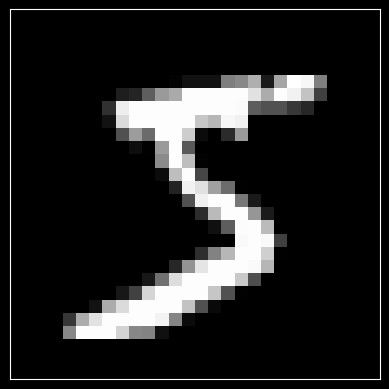

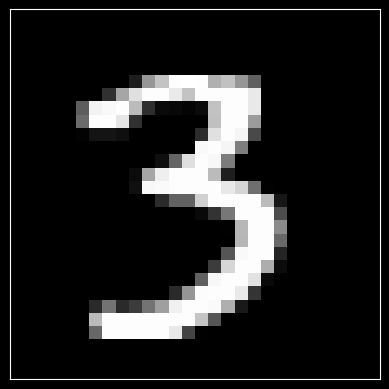

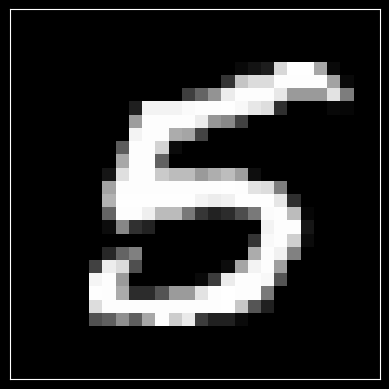

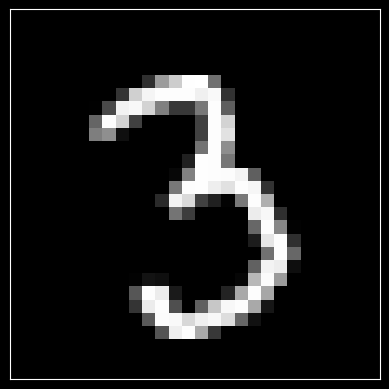

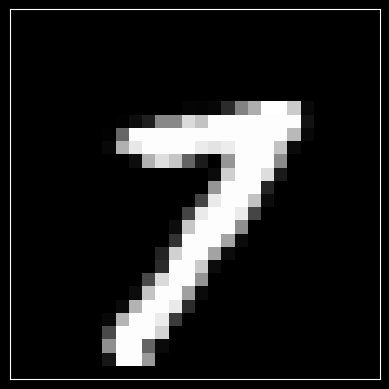

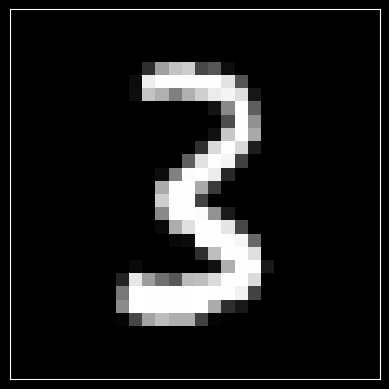

In [1]:
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils.model_util import *
from utils.train_util import *
from utils.data_util import *

torch.set_printoptions(
    precision=2,
    threshold=1000,
    edgeitems=5,
    linewidth=1000,
    sci_mode=False)



def data_loader(dataset, batch_size, shuffle=True, device='cuda'):  #
    num_data = len(dataset)
    data_idxs = [i for i in range(num_data)]
    if shuffle:
        random.shuffle(data_idxs)
    num_dataloader = num_data // batch_size
    if num_data % batch_size:
        num_dataloader += 1

    for i in range(num_dataloader):
        idx = i * batch_size
        if i == num_dataloader-1 and idx < num_data:
            image = ()
            target = ()
            for idx_single in range(idx, num_data):
                data = dataset[data_idxs[idx_single]]
                image += (data[0],)
                target += (data[1],)
            data_return = (torch.stack(image).to(device),
                           torch.tensor(target).to(device))
            yield data_return
        else:
            image = ()
            target = ()
            for idx_single in range(idx, idx+batch_size):
                data = dataset[data_idxs[idx_single]]
                image += (data[0],)
                target += (data[1],)
            data_return = (torch.stack(image).to(device),
                           torch.tensor(target).to(device))
            yield data_return


def dataloader_(dataset, batch_size, shuffle=True, device='cpu'):
    num_data = len(dataset)
    images = dataset.data.unsqueeze(1) / 255
    target = dataset.targets
    idxs = [i for i in range(num_data)]
    if shuffle:
        random.shuffle(idxs)
    num_dataloader = num_data // batch_size
    if num_data % batch_size:
        num_dataloader += 1
    for i in range(num_dataloader):
        idx = i * batch_size
        if i == num_dataloader-1 and idx < num_data:
            data_return = images[idx:]
            target_return = target[idx:]
            yield (data_return.to(device), target_return.to(device))
        else:
            data_return = images[idx: idx+batch_size]
            target_return = target[idx: idx+batch_size]
            yield (data_return.to(device), target_return.to(device))


if __name__ == '__main__':
    # 一次性将所有内容放到GPU上
    train_data, test_data, c, h, w = get_dataset()

    # train_data_loader = data_loader(train_data, 10000, shuffle=False)
    train_data_loader = dataloader_(train_data, 10000, shuffle=False)
    # train_data_loader  =DataLoader(train_data, batch_size=10000, shuffle=False)
    for images, targets in train_data_loader:
        # print(images[0][0].shape, images[0][0].device)
        plt.tight_layout
        plt.imshow(images[0][0], cmap='gray', interpolation='none')
        # plt.title("Ground Truth: {}".format(targets[0]))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        # break

In [7]:
import numpy as np

from utils.data_util import get_dataset

train_data, test_data, c, h, w = get_dataset('cifar10')

image, target = train_data[0][0], train_data[0][1]
CIFAR10_TRAIN_STD = np.array((0.2470, 0.2435, 0.2616))[None, :, None, None]
print(image.shape, target, CIFAR10_TRAIN_STD)

Files already downloaded and verified
torch.Size([3, 32, 32]) 6 [[[[0.247 ]]

  [[0.2435]]

  [[0.2616]]]]


In [24]:
import torch
import numpy as np

a = torch.ones([2, 3, 5, 5])
# print(a)
b = np.array((2, 3, 4), dtype='float32')[None, :, None, None]
c = a - b
print(c, c.dtype)

tensor([[[[-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.]],

         [[-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.]],

         [[-3., -3., -3., -3., -3.],
          [-3., -3., -3., -3., -3.],
          [-3., -3., -3., -3., -3.],
          [-3., -3., -3., -3., -3.],
          [-3., -3., -3., -3., -3.]]],


        [[[-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.]],

         [[-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.],
          [-2., -2., -2., -2., -2.]],

         [[-3., -3., -3., -3., -3.],
          [-3., -3., -3., 

In [6]:
import torch
import numpy as np

a = torch.ones([2, 3, 5, 5])
# print(a)
b = torch.tensor((2, 3, 4), dtype=torch.float32)
b1 = b[None, :, None, None]
b2 = b.unsqueeze(1).unsqueeze(1).unsqueeze(0)
print(b1.shape, b2.shape)
print(torch.eq(b1, b2))
# c = torch.tensor([1, 1, 1, 1])
# c[0, :, 0, 0] = b
# print(c, c.dtype)

torch.Size([1, 3, 1, 1]) torch.Size([1, 3, 1, 1])
tensor([[[[True]],

         [[True]],

         [[True]]]])


IndexError: too many indices for tensor of dimension 1

In [8]:
import numpy as np

from utils.data_util import get_dataset

train_data, test_data, c, h, w = get_dataset('cifar10')
image, _ = train_data[0]

print(image.shape, c, h, w)



Files already downloaded and verified
torch.Size([3, 32, 32]) 3 32 32
